In [1]:
import time
import json
import logging
import inspect
import itertools
import datetime
from concurrent import futures

import gym
from scipy import stats, special
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from banditry import models, versioning
from banditry.base import NotFitted
from banditry.experiment import Seedable, ReplicationMetrics, ExperimentMetrics, plot_cum_regret

logger = logging.getLogger()

In [2]:
%load_ext autoreload
%autoreload 2

# Contextual bandit OpenAI Gym Environment Implementation

In [4]:
env = gym.make('CartPole-v0')
obs = env.reset()

for t in range(1000):
    env.render()
    random_action = env.action_space.sample()
    obs, reward, done, info = env.step(random_action)
    if done:
        print(f"Episode finished after {t} timesteps")
        break

env.close()

Episode finished after 48 timesteps


In [5]:
env.action_space

Discrete(2)

In [6]:
env.observation_space

Box(4,)

In [7]:
env.observation_space.high

array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)

In [8]:
env.observation_space.low

array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32)

In [176]:
list(gym.envs.registry.all())[::100]

[EnvSpec(Copy-v0),
 EnvSpec(AirRaidDeterministic-v4),
 EnvSpec(BattleZone-ram-v4),
 EnvSpec(ChopperCommand-ramNoFrameskip-v4),
 EnvSpec(FrostbiteDeterministic-v4),
 EnvSpec(Krull-ram-v4),
 EnvSpec(Pooyan-ramNoFrameskip-v4),
 EnvSpec(SpaceInvadersDeterministic-v4),
 EnvSpec(WizardOfWor-ram-v4)]

In [10]:
spec = gym.envs.registry.spec('Hopper-v2')
{name: getattr(spec, name) for name in dir(spec)
 if not name.startswith('_')}

{'id': 'Hopper-v2',
 'make': <bound method EnvSpec.make of EnvSpec(Hopper-v2)>,
 'max_episode_seconds': None,
 'max_episode_steps': 1000,
 'nondeterministic': False,
 'reward_threshold': 3800.0,
 'tags': {'wrapper_config.TimeLimit.max_episode_steps': 1000},
 'timestep_limit': 1000,
 'trials': 100}

## Creating a new environment

I've pieced together the following from reading the `openai/gym` source code.

1.  A new environment can be registered by calling `gym.register(name, **kwargs)`
    1.  The name is a unique identifier string for the environment
    2.  The kwargs include a set of metadata. Some of this is optional. The important stuff seems to be:
        1.  `entry_point`: Environment class or full qualified path to the class (which will be loaded dynamically)
        2.  `trials`: number of trials to average reward over
        3.  `kwargs`: passed through to Environment class
        4.  `max_episode_steps`: specify max number of time steps per replication / trial. If you do this, you don't need to manage this in the lower-level environment. It will be wrapped in a `gym.wrappers.TimeLimit` which will set the `done` attribute to True when `step` has been called `max_episode_steps` times.
2.  Once registered, a new instance can be created by calling `gym.make(name)`
    1.  This will create a new Environment instance by passing in `**kwargs` to `entry_point
3.  Every `Environment` needs:
    1.  to implement 5 methods:
        1.  `reset()`: reset state of environment, and return initial observation
        2.  `step(action)`: run one timestep, return tuple of `(observation, reward, done, info)`
        3.  `seed(seed=None)`: set seed for env's RNG
        4.  `close()`: perform any necessary cleanup operations
        5.  `render(mode='human')`: render env if supported. This is not required, but it may be useful to implement something later on.
    2.  to set 2-3 attributes:
        1.  `action_space`: Space object representing valid actions
        2.  `observation_space`: Space object representing valid observations
        3.  (optional) `reward_range`: tuple specifying (min, max) of possible rewards, e.g. (0, 1) for binary

### ContextualBanditEnvironment

Each of our environments will be fully-characterized by:

1.  Number of arms
2.  Number of time steps
3.  Context-generating distribution for decision instances (i.e. population characteristics)
    -   which naturally encodes the number of context variables & covariates
4.  True effects for each context covariate for each arm (assumed linear)
5.  Random seed

The link function will be Binomial-logistic for all our simulations for now. So rewards will be binary.

The action space will be `range(num_arms)`.

The observation space will correspond to the context-generating distribution.

#### First environment

For the first environment, we'll have:

1. 10 real-valued context variables, with no interactions
2. Homogeneous effect sizes (all same variance)
3. 10 arms
4. 100 time steps

We'll start with what I believe is the simplest scenario:

-   9 of the arms will have exactly the same effects.
-   1 will have slightly better effects, so it is best for every context.

Contexts will be generated to be strictly positive, to make the setting of "better" effects as simple as increasing any of them.

This is part of the `OneBest` class of scenarios.

-   One arm is the best across all contexts and the rest are the same.

This will also be a `SparseRewards` scenario

-   where most reward distributions yield rewards very seldom (less than 5% of the time)

In [4]:
num_arms = 10
num_time_steps = 100
num_predictors = 10
shared_variance = 0.5

rng = np.random.RandomState(42)

In [5]:
# context-generating distribution
dist = stats.truncnorm(0, 10, loc=0, scale=shared_variance)
context = dist.rvs(num_predictors, random_state=rng)
context

array([0.2440635 , 0.98305592, 0.55383303, 0.41961388, 0.09840172,
       0.09838631, 0.03643071, 0.74959595, 0.42180713, 0.5269514 ])

In [6]:
rng.seed(42)
effect_dist = stats.norm(-1, 0.5)
shared_effects = effect_dist.rvs(size=num_predictors, random_state=rng)
special.expit(shared_effects.dot(context))

0.03545851034183353

In [7]:
arm_effects = np.tile(shared_effects, 9).reshape(9, num_predictors)
np.all(arm_effects[0] == arm_effects[1])

True

In [8]:
better_effects = shared_effects.copy()
better_effects += stats.truncnorm.rvs(0.4, 0.7, loc=0.5, scale=0.1, size=num_predictors)
special.expit(better_effects.dot(context))

0.26646318100820043

In [9]:
all_effects = np.ndarray((10, 10))
all_effects[:-1] = arm_effects
all_effects[-1] = better_effects
rates = special.expit(all_effects.dot(pd.Series(context)))
rates

array([0.03545851, 0.03545851, 0.03545851, 0.03545851, 0.03545851,
       0.03545851, 0.03545851, 0.03545851, 0.03545851, 0.26646318])

In [10]:
rewards = rng.binomial(n=1, p=rates)
optimal_action = rewards.argmax()
optimal_reward = rewards[optimal_action]
rewards, optimal_action, optimal_reward

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 0, 0)

In [11]:
s = gym.spaces.Box(low=0, high=np.inf, shape=(10,), dtype=np.float)
s.contains(np.array([10] * 11))

False

In [42]:
# For environment observation, we don't want to do any preprocessing,
# so just include arm as a categorical feature.
df = pd.Series(range(num_arms), dtype='category').to_frame('arm')
context_colnames = [f'p{i}' for i in range(num_predictors)]
for i in range(len(context)):
    df[f'p{i}'] = context[i]

df

,arm,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
0,0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
1,1,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
2,2,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
3,3,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
4,4,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
5,5,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
6,6,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
7,7,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
8,8,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
9,9,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951


In [159]:
# However, for the model, we'll still need to figure out
# how to preprocess the design matrix appropriately.
# First, dummy-encode and treatment code categoricals
from patsy import dmatrix, build_design_matrices

context_colnames = [f'p{i}' for i in range(num_predictors)]
factors = ['0', 'arm'] + context_colnames
interactions = False
if interactions:
    factors += [f'arm:{context_name}'
                for context_name in context_colnames]

dmat = dmatrix(' + '.join(factors), df)
design_matrix = pd.DataFrame(dmat, columns=dmat.design_info.column_names)
design_matrix

,arm[0],arm[1],arm[2],arm[3],arm[4],arm[5],arm[6],arm[7],arm[8],arm[9],p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951


In [147]:
# At decision time, we can repeat the preprocessing on the input
# context using the `design_info` property of the design matrix.
design_matrix2 = build_design_matrices(
    [dmat.design_info], df, return_type='dataframe')[0]
design_matrix2

,arm[0],arm[1],arm[2],arm[3],arm[4],arm[5],arm[6],arm[7],arm[8],arm[9],p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.244064,0.983056,0.553833,0.419614,0.098402,0.098386,0.036431,0.749596,0.421807,0.526951


Next, we need to figure out how to identify which of these resulting columns were originally categorical or real-valued.

In [96]:
real_colnames = set(df.select_dtypes(['int', 'float']).columns)
real_colnames

{'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9'}

In [97]:
cat_colnames = set(df.columns) - real_colnames
cat_colnames

{'arm'}

In [148]:
colnames = real_colnames | cat_colnames
list(itertools.combinations(colnames, 2))[:10]

[('arm', 'p4'),
 ('arm', 'p9'),
 ('arm', 'p2'),
 ('arm', 'p0'),
 ('arm', 'p7'),
 ('arm', 'p8'),
 ('arm', 'p6'),
 ('arm', 'p3'),
 ('arm', 'p5'),
 ('arm', 'p1')]

In [98]:
named_terms = {name: term for name, term in
               zip(dmat.design_info.term_names, dmat.design_info.terms)}
named_terms

{'arm': Term([EvalFactor('arm')]),
 'p0': Term([EvalFactor('p0')]),
 'p1': Term([EvalFactor('p1')]),
 'p2': Term([EvalFactor('p2')]),
 'p3': Term([EvalFactor('p3')]),
 'p4': Term([EvalFactor('p4')]),
 'p5': Term([EvalFactor('p5')]),
 'p6': Term([EvalFactor('p6')]),
 'p7': Term([EvalFactor('p7')]),
 'p8': Term([EvalFactor('p8')]),
 'p9': Term([EvalFactor('p9')])}

In [131]:
column_indices = np.arange(dmat.shape[1])
cat_indices = np.array(sorted(itertools.chain.from_iterable(
    column_indices[dmat.design_info.term_slices[named_terms[name]]]
    for name in cat_colnames)))
real_indices = np.array(sorted(itertools.chain.from_iterable(
    column_indices[dmat.design_info.term_slices[named_terms[name]]]
    for name in real_colnames)))
cat_indices, real_indices

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]))

In [123]:
# Now construct the prior mapping from this.
mapping = np.zeros(design_matrix.shape[1], dtype=np.int)
mapping[real_indices] = 1
mapping

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Contextual Environment

In [48]:
class ContextualBanditEnv(Seedable, gym.Env):

    def __init__(self, num_arms, num_context, num_time_steps, **kwargs):
        Seedable.__init__(self, **kwargs)  # implements seed and reset

        self.num_arms = num_arms
        self.num_context = num_context
        self.num_predictors = 1 + num_context  # 1 is for recording arm
        self.num_time_steps = num_time_steps

        self.action_space = gym.spaces.Discrete(self.num_arms)
        self.observation_space = gym.spaces.Box(
            low=0, high=np.inf, shape=(self.num_predictors,), dtype=np.float)
        self.reward_range = (0, 1)

        self._context_colnames = [f'p{i}' for i in range(num_context)]
        self._base_obs = pd.Series(range(num_arms), dtype='category').to_frame('arm')
        self._last_observation = None

        # Set up context distribution
        shared_variance = 0.5
        self.context_dist = stats.truncnorm(0, 10, loc=0, scale=shared_variance)

        # Set up arm effects.
        self.arm_effects = np.ndarray((self.num_arms, self.num_context))

        # All but one of the arms will have the same effects.
        effect_dist = stats.norm(-1, 0.5)
        shared_effects = effect_dist.rvs(size=self.num_context, random_state=self.rng)
        self.arm_effects[:-1] = (np.tile(shared_effects, self.num_arms - 1)
                                   .reshape(self.num_arms - 1, self.num_context))

        # The last one will have just slightly better effects.
        self.arm_effects[-1] = shared_effects + stats.truncnorm.rvs(
            0.4, 0.7, loc=0.5, scale=0.1,
            size=self.num_context, random_state=self.rng)

    def _next_observation(self):
        context = self.context_dist.rvs(size=self.num_context, random_state=self.rng)
        self._last_context = pd.Series(context)

        obs = self._base_obs.copy()
        for i, name in enumerate(self._context_colnames):
            obs[name] = context[i]

        self._last_observation = obs
        return self._last_observation

    def reset(self):
        Seedable.reset(self)
        return self._next_observation()

    def step(self, action):
        rates = special.expit(self.arm_effects.dot(self._last_context))
        rewards = self.rng.binomial(n=1, p=rates)
        optimal_action = rates.argmax()
        optimal_reward = rewards[optimal_action]
        actual_reward = rewards[action]

        info = dict(optimal_action=optimal_action,
                    optimal_reward=optimal_reward)
        next_observation = self._next_observation()
    
        done = False  # will be handled by wrapper
        return next_observation, actual_reward, done, info

In [49]:
env_name = 'CMABRealsOnebestN10P10T100-v0'
gym.envs.registry.env_specs.pop(env_name, None)

num_time_steps = 1000
gym.envs.register(
    env_name,
    trials=100, max_episode_steps=num_time_steps,
    entry_point=ContextualBanditEnv, kwargs=dict(
        num_arms=10, num_context=10, num_time_steps=num_time_steps, seed=42))

In [50]:
cmab_env = gym.envs.make(env_name)
cmab_env

<TimeLimit<ContextualBanditEnv<CMABRealsOnebestN10P10T100-v0>>>

In [51]:
obs = cmab_env.reset()

all_rewards = np.ndarray((num_time_steps,))
optimal_rewards = np.ndarray((num_time_steps,))

for t in range(num_time_steps):
    random_action = cmab_env.action_space.sample()
    obs, reward, done, info = cmab_env.step(random_action)
    all_rewards[t] = reward
    optimal_rewards[t] = info['optimal_reward']
    if done:
        print(f"Episode finished after {t+1} timesteps")
        break

regret = optimal_rewards - all_rewards
np.sum(regret)

Episode finished after 1000 timesteps


206.0

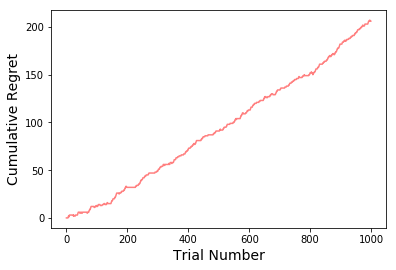

In [52]:
plot_cum_regret(all_rewards, optimal_rewards);

## Wrapper class to record metrics

In [6]:
class MetricsRecorder(gym.Wrapper):
    """Record metrics from an agent interacting with the wrapped environment."""

    def __init__(self, env):
        super().__init__(env)
        self.metrics = None
        self._current_step = 0
        self._compute_start = None
        self._last_observation = None

    def step(self, action):
        assert self._compute_start is not None, "Cannot call env.step() before calling reset()"
        time_for_decision = time.time() - self._compute_start
        observation, reward, done, info = self.env.step(action)

        # Record outcomes for this step
        t = self._current_step  # will be 0 on first call to step
        self.metrics.design_matrix[t] = self._last_observation.iloc[action]
        self.metrics.time_per_decision[t] = time_for_decision
        self.metrics.actions[t] = action
        self.metrics.optimal_actions[t] = info.get('optimal_action', np.nan)
        self.metrics.rewards[t] = reward
        self.metrics.optimal_rewards[t] = info.get('optimal_reward', np.nan)
        
        # Move to next step and restart timer
        self._current_step += 1
        if not done:
            self._last_observation = observation
            self._compute_start = time.time()  # reset compute timer
        else:
            self._compute_start = None
            self.metrics.end = datetime.datetime.now()

        return observation, reward, done, info

    def reset(self, **kwargs):
        self._last_observation = self.env.reset(**kwargs)
        self.metrics = ReplicationMetrics(
            self.env.initial_seed, self.env.num_time_steps, self.env.num_predictors)
        self.metrics.start = datetime.datetime.now()

        self._current_step = 0
        self._compute_start = time.time()
        return self._last_observation

In [7]:
cmab_env = gym.envs.make(env_name)
cmab_env = MetricsRecorder(cmab_env)
cmab_env

<MetricsRecorder<TimeLimit<ContextualBanditEnv<CMABRealsOnebestN10P10T100-v0>>>>

In [23]:
obs = cmab_env.reset()

while True:
    random_action = cmab_env.action_space.sample()
    obs, reward, done, info = cmab_env.step(random_action)
    if done:
        break

In [11]:
results = cmab_env.metrics.as_df()
results.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p15,p16,p17,p18,p19,_action_,_optimal_action_,_reward_,_optimal_reward_,_compute_time_
time_step,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,1,0,0,0,0,0,...,0.0983863,0.0364307,0.749596,0.421807,0.526951,4,9,0.0,0.0,0.000139
1,0,1,0,0,0,0,0,0,0,0,...,0.620205,0.126462,0.34853,0.414075,0.0291249,1,9,0.0,0.0,0.000025
2,0,0,0,0,0,0,0,1,0,0,...,0.47958,0.200589,0.353206,0.374971,0.116897,7,9,0.0,0.0,0.000021
3,0,0,1,0,0,0,0,0,0,0,...,0.371647,0.0887754,0.643918,0.0467859,1.24034,2,9,0.0,0.0,0.000022
4,0,0,0,1,0,0,0,0,0,0,...,0.209773,0.551078,0.45536,0.792894,0.315695,3,9,0.0,0.0,0.000028


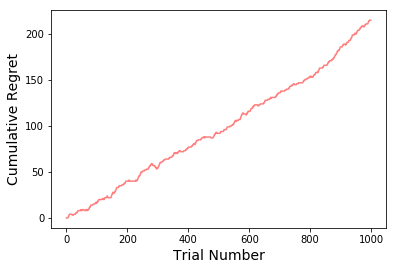

In [12]:
plot_cum_regret(results['_reward_'].values, results['_optimal_reward_'].values);

In [8]:
num_covariates = cmab_env.num_predictors
model = models.LogisticRegression(
    m0=np.zeros(num_covariates),
    P0=np.identity(num_covariates, dtype=np.float),
    num_samples=2)  # first sample discarded as burnin
model

In [14]:
SEED = 42
model.seed(SEED)
cmab_env.seed(SEED)

obs = cmab_env.reset()

all_actions = []
for t in range(1000):
    if t % 50 == 0:
        print(f'Step {t+1}')

    action = model.choose_arm(obs)
    all_actions.append(action)
    obs, reward, done, info = cmab_env.step(action)
    if done:
        print(f"Episode finished after {t+1} timesteps")
        break
    else:
        model.fit(cmab_env.metrics.design_matrix[:t],
                  cmab_env.metrics.rewards[:t])

Step 1
Step 51
Step 101
Step 151
Step 201
Step 251
Step 301
Step 351
Step 401
Step 451
Step 501
Step 551
Step 601
Step 651
Step 701
Step 751
Step 801
Step 851
Step 901
Step 951
Episode finished after 1000 timesteps


Regret: 48.0


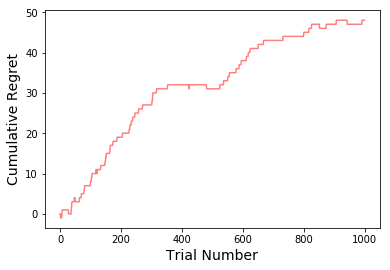

In [15]:
results = cmab_env.metrics.as_df()
regret = results['_optimal_reward_'].values - results['_reward_'].values
print(f'Regret: {np.sum(regret)}')
plot_cum_regret(results['_reward_'].values, results['_optimal_reward_'].values);

In [16]:
results[cmab_env.metrics.metadata_colnames].iloc[::50]

,_action_,_optimal_action_,_reward_,_optimal_reward_,_compute_time_
time_step,,,,,
0,3,9,0.0,0.0,0.331051
50,1,9,1.0,0.0,0.002141
100,5,9,0.0,1.0,0.002833
150,8,9,0.0,1.0,0.002737
200,9,9,0.0,0.0,0.002225
250,9,9,1.0,1.0,0.002515
300,9,9,0.0,0.0,0.002289
350,9,9,1.0,1.0,0.002704
400,9,9,1.0,1.0,0.002629


In [17]:
results._optimal_action_.astype(int).value_counts()

9    1000
Name: _optimal_action_, dtype: int64

In [18]:
results._action_.astype(int).value_counts()

9    802
5     31
1     29
6     22
2     22
8     21
4     21
7     20
3     16
0     16
Name: _action_, dtype: int64

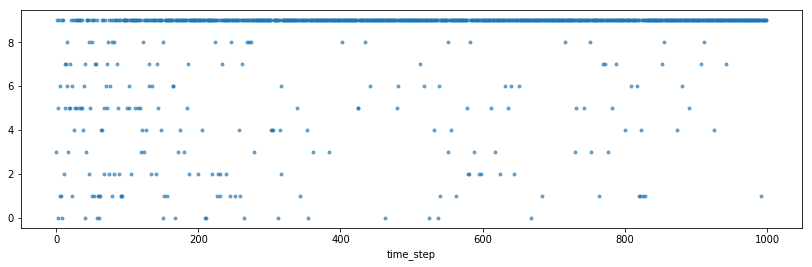

In [19]:
fig, ax = plt.subplots(figsize=(14, 4))
jitter = 0#np.random.normal(0, 0.03, size=len(results))
(results._action_ + jitter).plot(marker='o', markersize=3, linestyle='', alpha=0.6, ax=ax);

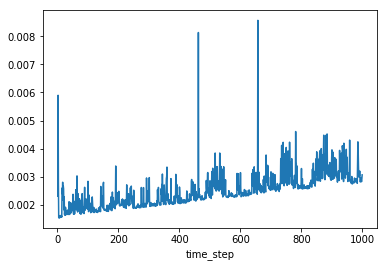

In [21]:
results._compute_time_[1:].plot();

### Storing replication metadata

In [30]:
# Simulation name
cmab_env.env.spec.id

'CMABRealsOnebestN10P10T100-v0'

In [31]:
# Random seed
cmab_env.unwrapped.initial_seed

42

In [118]:
# Name of model
f'{model.__class__.__module__}.{model.__class__.__name__}'

'models.LogisticRegression'

In [33]:
# Hash of model source
from versioning import hash_class
hash_class(model.__class__)

-341466408474626320

In [59]:
# Hyperparameter settings
argspec = inspect.getfullargspec(model.__class__)
argspec

FullArgSpec(args=['self', 'm0', 'P0'], varargs=None, varkw='kwargs', defaults=(None, None), kwonlyargs=[], kwonlydefaults=None, annotations={})

In [60]:
argspec.args[1:]

['m0', 'P0']

In [54]:
def get_parents_with_hyperparams(klass):
    cutoff_set = {models.PGBaseModel, models.BaseModel}
    super_classes = klass.mro()

    idx = None
    for base_class in cutoff_set:
        try:
            idx = super_classes.index(base_class)
            break
        except ValueError:
            pass

    return super_classes[1:idx]


get_parents_with_hyperparams(model.__class__)

[models.MCMCLogisticRegression]

In [57]:
def get_hyperparam_names(klass):
    parents = get_parents_with_hyperparams(klass)
    all_classes = [klass] + parents
    return set(itertools.chain.from_iterable(
        inspect.getfullargspec(class_ref).args[1:]  # exclude self
        for class_ref in all_classes))


get_hyperparam_names(model.__class__)

{'P0', 'm0', 'num_burnin', 'num_samples'}

In [62]:
def get_hyperparams(model):
    names = get_hyperparam_names(model.__class__)
    return {name: getattr(model, name) for name in names}


hyperparams = get_hyperparams(model)
hyperparams

{'num_samples': 2,
 'num_burnin': 0,
 'm0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'P0': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 

In [150]:
# This functionality has been attached to the model classes
model.get_hyperparams()

{'num_samples': 2,
 'num_burnin': 0,
 'm0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'P0': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 

#### Implement some special serialization logic for handling numpy arrays to JSON

In [63]:
m0 = hyperparams['m0']
P0 = hyperparams['P0']

In [132]:
def is_diagonal(matrix):
    return np.count_nonzero(matrix - np.diag(np.diagonal(matrix))) == 0


def is_identity(matrix):
    return (is_diagonal(matrix) and
            np.all(np.diag(matrix) == 1))


is_diagonal(P0), is_identity(P0)

(True, True)

In [98]:
def is_zeros(array):
    return np.all(array == 0)


is_zeros(m0), is_zeros(P0)

(True, False)

In [113]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            # process several special cases: zeros, diagonal, identity
            values = None
            if is_zeros(obj):
                constructor = 'zeros'
            elif is_identity(obj):
                constructor = 'identity'
            elif is_diagonal(obj):
                constructor = 'diag'
                values = np.diagonal(obj).tolist()
            else:
                constructor = 'array'
                values = obj.tolist()

            return {
                'dtype': f'{obj.dtype}',
                'constructor': constructor,
                'values': values,
                'shape': obj.shape
            }

        return json.JSONEncoder.default(self, obj)
    
as_json = json.dumps(hyperparams, cls=NumpyEncoder)
as_json

'{"num_samples": 2, "num_burnin": 0, "m0": {"dtype": "float64", "constructor": "zeros", "values": null, "shape": [20]}, "P0": {"dtype": "float64", "constructor": "identity", "values": null, "shape": [20, 20]}}'

In [114]:
def decode_object(decoded_dict):
    if 'dtype' in decoded_dict:
        constructor_name = decoded_dict['constructor']
        if constructor_name == 'array':
            return np.array(decoded_dict['values'], dtype=decoded_dict['dtype'])
        elif constructor_name == 'diag':
            return np.diag(decoded_dict['values']).astype(decoded_dict['dtype'])
        elif constructor_name == 'identity':
            return np.identity(decoded_dict['shape'][0], dtype=decoded_dict['dtype'])
        else:
            constructor = getattr(np, constructor_name)
            return constructor(decoded_dict['shape'], dtype=decoded_dict['dtype'])
    
    return decoded_dict


as_json == json.dumps(json.loads(as_json, object_hook=decode_object), cls=NumpyEncoder)

True

### Now, let's figure out how the experiment metrics will be stored

In [ ]:
# index.json file will look like this:
{
    'metadata': {
        'env_name': 'CMABRealsOnebestN10P10T100-v0',
        'model_name': 'models.LogisticRegression',
        'model_hash': -341466408474626320,
        'hyperparams': hyperparams
    },
    'replications': [{
        'metrics_path': '/path/to/metrics_0.csv',
        'seed': 0,
        'start_timestamp': 'yyyy-mm-ddThh:mm:ss.ffffff',  # assumed UTC
        'end_timestamp': 'yyyy-mm-ddThh:mm:ss.ffffff'
    }, {
        'metrics_path': '/path/to/metrics_1.csv',
        'seed': 1,
        'start_timestamp': 'yyyy-mm-ddThh:mm:ss.ffffff',  # assumed UTC
        'end_timestamp': 'yyyy-mm-ddThh:mm:ss.ffffff'
    }]
}

In [ ]:
# Directory structure will then look like this:
"""
./index.json
./replications/metrics_0.csv
./replications/metrics_1.csv
"""

In [128]:
import datetime
dt = datetime.datetime.now()
dt

datetime.datetime(2019, 4, 16, 10, 33, 51, 429461)

In [129]:
dt.isoformat()

'2019-04-16T10:33:51.429461'

In [130]:
datetime.datetime.strptime(dt.isoformat(), '%Y-%m-%dT%H:%M:%S.%f')

datetime.datetime(2019, 4, 16, 10, 33, 51, 429461)

In [9]:
class Experiment(Seedable):
    def __init__(self, model, env, *,
                 logging_frequency=100, max_workers=None, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        self.env = env

        self.logging_frequency = logging_frequency
        self.max_workers = max_workers

    @property
    def num_time_steps(self):
        return self.env.spec.max_episode_steps

    @property
    def metadata(self):
        return {
            'env_name': self.env.env.spec.id,
            'num_time_steps': self.num_time_steps,
            'model_name': f'{self.model.__class__.__module__}.{self.model.__class__.__name__}',
            'model_hash': versioning.hash_class(self.model.__class__),
            'hyperparams': self.model.get_hyperparams()
        }

    def run(self, num_replications=1):
        exp_metrics = ExperimentMetrics(self.metadata)
        rep_nums = np.arange(num_replications)
        with futures.ProcessPoolExecutor(max_workers=self.max_workers) as pool:
            all_metrics = pool.map(self.run_once, rep_nums)

        exp_metrics.add_replications(all_metrics)
        return exp_metrics

    def run_once(self, seed):
        self.model.seed(seed)
        self.env.seed(seed)

        obs = self.env.reset()

        for t in range(self.num_time_steps):
            if (t + 1) % self.logging_frequency == 0:
                logger.info(f'Experiment_{seed} at t={t + 1}')

            try:
                action = model.choose_arm(obs)
            except NotFitted:
                action = self.env.action_space.sample()

            obs, reward, done, info = self.env.step(action)
            if done:
                logger.info(f"Replication finished after {t+1} timesteps")
                break
            else:
                past_contexts = self.env.metrics.design_matrix[:t]
                past_rewards = self.env.metrics.rewards[:t]
                model.fit(past_contexts, past_rewards)

        return self.env.metrics

In [10]:
exp = Experiment(model, cmab_env)
exp.metadata

{'env_name': 'CMABRealsOnebestN10P10T100-v0',
 'num_time_steps': 1000,
 'model_name': 'banditry.models.LogisticRegression',
 'model_hash': 1209317936077155960,
 'hyperparams': {'m0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  'num_samples': 2,
  'P0': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.,

In [11]:
metrics = exp.run(2)

Regret: 45.0


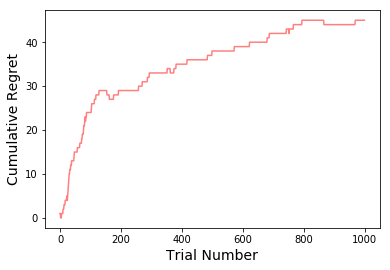

In [12]:
results = metrics[0].as_df()
regret = results['_optimal_reward_'].values - results['_reward_'].values
print(f'Regret: {np.sum(regret)}')
plot_cum_regret(results['_reward_'].values, results['_optimal_reward_'].values);

Regret: 32.0


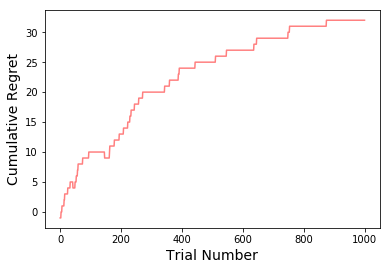

In [13]:
results = metrics[1].as_df()
regret = results['_optimal_reward_'].values - results['_reward_'].values
print(f'Regret: {np.sum(regret)}')
plot_cum_regret(results['_reward_'].values, results['_optimal_reward_'].values);

In [14]:
!rm -rf tmp

In [15]:
metrics.save('tmp')

In [16]:
!ls tmp

index.json   replications


In [17]:
!ls tmp/replications/

0.csv 1.csv


In [18]:
!cat tmp/index.json

{"metadata": {"env_name": "CMABRealsOnebestN10P10T100-v0", "num_time_steps": 1000, "model_name": "banditry.models.LogisticRegression", "model_hash": 1209317936077155960, "hyperparams": {"m0": {"dtype": "float64", "constructor": "zeros", "values": null, "shape": [20]}, "num_samples": 2, "P0": {"dtype": "float64", "constructor": "identity", "values": null, "shape": [20, 20]}, "num_burnin": 0}}, "replications": [{"metrics_path": "replications/0.csv", "seed": 0, "start_time": "2019-04-16T13:29:52.965731", "end_time": "2019-04-16T13:30:00.863938"}, {"metrics_path": "replications/1.csv", "seed": 1, "start_time": "2019-04-16T13:29:52.965701", "end_time": "2019-04-16T13:30:00.863771"}]}

In [23]:
metrics

ExperimentMetrics(metadata={'env_name': 'CMABRealsOnebestN10P10T100-v0', 'num_time_steps': 1000, 'model_name': 'banditry.models.LogisticRegression', 'model_hash': 1209317936077155960, 'hyperparams': {'m0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 'num_samples': 2, 'P0': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 

In [56]:
m2 = ExperimentMetrics.load('tmp')
m2

ExperimentMetrics(metadata={'env_name': 'CMABRealsOnebestN10P10T100-v0', 'num_time_steps': 1000, 'model_name': 'banditry.models.LogisticRegression', 'model_hash': 1209317936077155960, 'hyperparams': {'m0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 'num_samples': 2, 'P0': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 

In [57]:
metrics == m2

True